In [1]:
import torch
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load a pre-trained DeepLabV3 model with a ResNet-50 backbone
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.eval()  # Set to evaluation mode


C:\Users\singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to C:\Users\singh/.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:19<00:00, 8.44MB/s] 


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [2]:
from torchvision import transforms
from PIL import Image

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load an image
image_path = "img3.jpg"  # Replace with an actual image path
image = Image.open(image_path).convert("RGB")
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_image)["out"][0]  # Get the segmentation output

# Convert output to segmentation map
segmentation_map = torch.argmax(output, dim=0).byte().cpu().numpy()


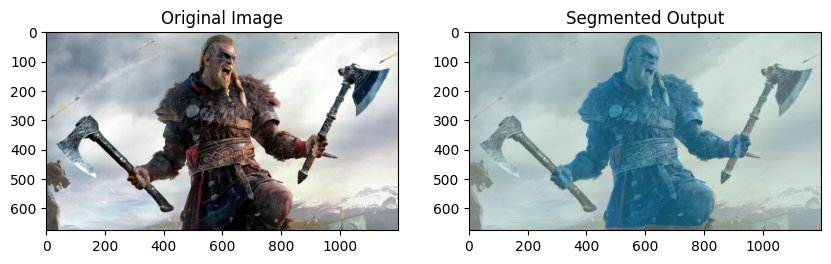

In [3]:
def visualize_segmentation(image, segmentation_map):
    color_map = np.random.randint(0, 255, (21, 3), dtype=np.uint8)  # 21 classes (for COCO dataset)
    color_segmentation = color_map[segmentation_map]

    blended = cv2.addWeighted(np.array(image), 0.5, color_segmentation, 0.5, 0)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title("Segmented Output")
    plt.show()

# Visualize the segmentation
visualize_segmentation(image, segmentation_map)


In [4]:
from torch.utils.data import Dataset, DataLoader

class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Load mask as grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(np.array(mask), dtype=torch.long)  # Convert to tensor
        
        return image, mask


In [8]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
def train(model, dataloader, epochs=5):
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader)}")

# Example DataLoader (replace with actual dataset)
image_paths = ["image3.jpg", "image4.jpg"]  # Replace with actual file paths
mask_paths = ["mask1.png", "mask2.png"]
dataset = CustomSegmentationDataset(image_paths, mask_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Train model
train(model, dataloader, epochs=5)


FileNotFoundError: Image file not found: image3.jpg